<a href="https://colab.research.google.com/github/jeffersonrodriguezc/thenanblog/blob/master/_notebooks/2021-06-14-SLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: How to translate Sign language from video to text
> In this tutorial we will explain the main steps to translate video signs to text translation. All the necessary steps and the seq2seq models to do it.

- toc:true- branch: master
- badges: true
- comments: true
- author: Jefferson Rodríguez
- categories: [SLT, SLR, seq2seq]

# Imports (libraries)

In [3]:
#collapse-hide
!pip install -q torchfile
!pip install -q tensorflow-addons
import os
import cv2
import copy
import time
import math
import h5py
import json
import codecs
import pickle
import shutil
import psutil
import imageio
import datetime
import torchfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from PIL import ImageFile
from skimage.io import imread
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as pimage
from collections import namedtuple
from collections import defaultdict
from skimage.transform import resize
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.backend import mean
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.random.set_seed(1031)
np.random.seed(1031)
K.set_image_data_format("channels_last")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# What is Sign languge translation??

# Step 1: Select and explore a sign language dataset.

In this tutorial we are going to use the Colombian sign language dataset presented in this [paper](https://openaccess.thecvf.com/content/ACCV2020/html/Rodriguez_Understanding_Motion_in_Sign_Language_A_New_Structured_Translation_Dataset_ACCV_2020_paper.html) (*Understanding Motion in Sign Language: A New Structured Translation Dataset*).  The dataset contains 1020 videos, 39 sentences from 9 signers and can be downloaded from this [website](https://bivl2ab.gitlab.io/research/2020-juan-colombiansld/lscd/). The dataset contains pre-calculated information such as flow, open poses and dense poses. However, in this post we only cover the RGB videos.

## Task 1: Create the dataset using generators and *tensorflow data API*

In [ ]:
#collapse-hide
class generator(object):
    """
    Generator class to read the video and the corresponding translation at the same time.
    """
    def __init__(self, paths_sentences, padded_sentences, params):
        'Initialization'
        self.dim = params.inputShape
        self.vocab_size = params.vocab_size
        self.list_IDs = np.random.permutation(paths_sentences)
        self.paths_sentences = paths_sentences
        self.padded_sentences = padded_sentences

    def read_video(self, path_video):
        """
        Function to read the video. 
        """
        # list in order all frames of the video
        frames = sorted(os.listdir(path_video))
        video = []
        for frame in sorted(frames):
            frame_rgb = imageio.imread()                       
            video.append(total_frame)
        
        return np.array(video)     

    def get_next(self):
        for idx in range(len(self.list_IDs)):
            path_video = os.path.join(self.list_IDs[idx])
            index = np.argwhere(self.paths_sentences==self.list_IDs[idx])[0]
            padded_sentence = self.padded_sentences[index,:-1]
            target = self.padded_sentences[index,1:]                
            video = self.read_video(path_video)
             
            yield {"encoder_input":video, 
                   "decoder_input":np.squeeze(padded_sentence),
                   "path":[path_video]}, np.squeeze(target)

### 2. Parameters

In [ ]:
#@title pameters (namedtuple) { display-mode: "form" }
Args = namedtuple('Args', ['tx', 
                           'ty',
                           'inputShape',
                           'denseUnits',
                           'rnnUnits',
                           'selfUnits',
                           'unitsEmbedding',
                           'vocab_size',
                           'dropout',
                           'recurrent_dropout', 
                           'epochs',
                           'nIters',
                           'batchSize',
                           'lr',
                           'decay',
                           'weight_decay',
                           'prefetch_batch_buffer', 
                           'dataset',
                           'data',
                           'videos_path',
                           'path2save',
                           'name',
                           'sets',
                           'subsampling',
                           'pad',
                           'augmentation',
                           'kpoints',
                           'maxframes',
                           'weights',
                           'layer2freeze',
                           'method'])

args = Args(tx=112, 
            ty=14,
            inputShape=(112, 112, 112, 3),
            denseUnits=512,
            rnnUnits=512,
            selfUnits=64,
            unitsEmbedding=300,
            vocab_size=117,
            dropout=0.2,
            recurrent_dropout=0.2,
            epochs=10,
            nIters=6.0,
            batchSize=1,
            lr=0.001,
            decay=0.1,
            weight_decay=0.0005,
            prefetch_batch_buffer = 5,
            dataset='LSCD',
            data='/data/Datasets/signlanguage/LSCD/data/split1/',
            videos_path='/data/Datasets/signlanguage',
            path2save=os.getcwd()+'/results/translations/',
            name='LSCD',
            sets=['train', 'test'],
            subsampling='volume',
            pad='zeros',
            augmentation=['noflip'],
            kpoints = 122,
            maxframes = 598,
            weights = 'ucf1_rgb100_fromC3D_71',
            layer2freeze = 50,
            method = 'flow') #FlowNet2png

### Dataset and text processing helpers

In [ ]:
#@title helper functions for text proccesing
def preprocessing_paths(video_paths, path2videos):
    """
    This functions chage the path placeholder for the right path
    """
    paths = list()
    for video_path in video_paths:
        folder = video_path.split('.')[-1]
        with codecs.getreader("utf-8")(tf.io.gfile.GFile(video_path, "rb")) as f:
            for path in f:
                new_path = path.replace('<PATH_TO_EXTRACTED_AND_RESIZED_FRAMES>', path2videos).strip()
                if len(new_path) > 1:
                    paths.append([new_path, folder])
    return paths

def preprocessing_sentences(paths_sentences):
  """ 
  This functions build the vocab from path of sentences
  """
  lens = []
  for path in paths_sentences:
    with codecs.getreader("utf-8")(tf.io.gfile.GFile(path, "rb")) as f:
      for sentence in f:
        lens.append(len(sentence.split(' '))+2)
  max_len = max(lens)
  outputs = list()
  tokenizer = Tokenizer(oov_token='<unk>', 
                        filters='!"#$%&()*+,-:;=@[\\]^_`{|}~\t\n')
  for path in paths_sentences:
    sentences = list()
    if path.split('.')[-1] == 'train':  
      print('Reading training file ...')  
      with codecs.getreader("utf-8")(tf.io.gfile.GFile(path, "rb")) as f:
        for sentence in f:
          sentences.append('<s> ' + sentence.strip() + ' </s>')
        print('training on train sentences to make the vocab ...')
        tokenizer.fit_on_texts(sentences)
        tokenizer.word_index['<pad>'] = 0
        tokenizer.index_word[0] = '<pad>'
        print('training text to index sequences ..')
        sequences_token = tokenizer.texts_to_sequences(sentences)
        print('training index sequences to padded sequences ..')
        sequences_padded = pad_sequences(sequences_token, maxlen=max_len,
                                         padding='post')
        outputs.append(sequences_padded)
    else:
      print('Computing same steps over dev and test sequences')
      with codecs.getreader("utf-8")(tf.io.gfile.GFile(path, "rb")) as f:
        for sentence in f:
          sentences.append('<s> ' + sentence.strip() + ' </s>')  
        sequences_token = tokenizer.texts_to_sequences(sentences)
        sequences_padded = pad_sequences(sequences_token, maxlen=max_len,
                                         padding='post')
        outputs.append(sequences_padded)           
  return (outputs, tokenizer) 

def predataset_(preprocessed_paths, preprocessed_sentences, params):
  """
  Pre-dataset - Create the np.arrays 
  """
  print('pre dataset creating ..')
  # dim == (#sentences, set)
  preprocessed_paths = np.array(preprocessed_paths)
  # dim == (#sentences, #numwordspersentence)
  if len(params.sets) > 2:
    padded_sentences = np.concatenate([preprocessed_sentences[0],
                                       preprocessed_sentences[1],
                                       preprocessed_sentences[2]])
  else:
    padded_sentences = np.concatenate([preprocessed_sentences[0],
                                       preprocessed_sentences[1]])    


  return [preprocessed_paths, padded_sentences] 

def count_frames(path, folder='jpg'):
    frames_counter = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        if dirpath.split('/')[-1] == folder:
            frames_counter.append(len(os.listdir(dirpath)))
    return frames_counter  

#@title Generators and datasets
class GeneratorSLT(object):
    def __init__(self, paths_sentences, padded_sentences, params):
        'Initialization'
        self.dim = params.inputShape
        self.pad = params.pad
        self.vocab_size = params.vocab_size
        self.subsampling = params.subsampling
        self.list_IDs = np.random.permutation(paths_sentences)
        self.paths_sentences = paths_sentences
        self.padded_sentences = padded_sentences
        #self.type = params.type
        self.max_len = params.maxframes
        self.method = params.method
        #self.idx = 0

    def read_images_and_process(self, path_video):
        # select path list to read first
        frames = sorted(os.listdir(os.path.join(path_video, 'flow')))
        # selecting paths
        frames_sampled = self.video_proccesing(frames) 
        # read selecting frames
        video = []
        for frame in sorted(frames_sampled):
            if frame == 'blanck':
                total_frame = np.zeros((self.dim[1],self.dim[2],self.dim[3]))
            else:
                if self.method == 'concat':
                    frame_dense_pose = imageio.imread(os.path.join(path_video, 'DensePose', frame.replace('.ppm','.png')))
                    frame_rgb = imageio.imread(os.path.join(path_video, 'png', frame.replace('.ppm','.png'))) 
                    frame_flow = imageio.imread(os.path.join(path_video, 'flow', frame))
                    total_frame = np.concatenate([frame_rgb,frame_flow,frame_dense_pose], axis=-1)
                    total_frame = resize(total_frame/255.,(self.dim[1],self.dim[2]))
                elif self.method in ['flow', 'FlowNet2png']:
                    if self.method == 'FlowNet2png':
                        frame_flow = imageio.imread(os.path.join(path_video, self.method, frame.replace('.ppm','.png')))
                    else:    
                        frame_flow = imageio.imread(os.path.join(path_video, self.method, frame))
                    total_frame = resize(frame_flow/255.,(self.dim[1],self.dim[2]))   
                elif self.method == 'RGB':
                    frame_rgb = imageio.imread(os.path.join(path_video, 'png', frame.replace('.ppm','.png'))) 
                    total_frame = resize(frame_rgb/255.,(self.dim[1],self.dim[2]))                       
                elif self.method == 'merge':
                    frame_dense_pose = imageio.imread(os.path.join(path_video, 'DensePose', frame.replace('.ppm','.png')))
                    frame_rgb = imageio.imread(os.path.join(path_video, 'png', frame.replace('.ppm','.png'))) 
                    frame_flow = imageio.imread(os.path.join(path_video, 'flow', frame))
                    total_frame = np.add.reduce([frame_rgb,frame_flow,frame_dense_pose])
                    total_frame = resize(total_frame/np.max(total_frame),(self.dim[1],self.dim[2]))
            video.append(total_frame)
        
        return np.array(video) 
    
    def video_padding(self, frames):
        
        if self.pad == 'zeros':
            for _ in range(self.dim[0]-len(frames)):
                path_pivot = 'blanck'
                frames.append(path_pivot)
        
        elif self.pad == 'copy_final_frame':
            last_frame = frames[-1]
            for _ in range(self.dim[0]-len(frames)): 
                frames.append(last_frame)
        
        return frames     

    def video_subsampling(self, frames, value=128):
        if self.subsampling == 'volume':  
            flag = True
            while flag:
                len_sign = len(frames)
                dif =  len_sign - int(value)
                if dif != 0:
                    step = int(np.ceil(len_sign/dif))
                    sub = [i for ind, i in enumerate(frames) if ind%step!=0]
                    frames = sub
                    if len(frames) == value:
                        flag = False
                else:
                    flag = False
        elif self.subsampling == 'first':             
            frames = frames[:value]

        return frames        

    def video_proccesing(self, frames):
        if self.dim[0]-len(frames) > 0:
            frames = self.video_padding(frames) 
        else:
            frames = self.video_subsampling(frames, self.dim[0])
        return frames 

    def get_next_triplet(self):
        for idx in range(len(self.list_IDs)):
            path_video = os.path.join(self.list_IDs[idx])
            path_open = os.path.join(path_video, 'OpenPose')
            openpose = distances_openpose(path_open, self.max_len)
            index = np.argwhere(self.paths_sentences==self.list_IDs[idx])[0]
            padded_sentence = self.padded_sentences[index,:-1]
            target = self.padded_sentences[index,1:]                
            #target = tf.keras.utils.to_categorical(padded_sentence[index,1:], num_classes=self.vocab_size)
            video = self.read_images_and_process(path_video)
             
            yield {"encoder_input":video, 
                   "encoder_input_2":openpose.T, 
                   "decoder_input":np.squeeze(padded_sentence),
                   "path":[path_video]}, np.squeeze(target)   

         
def flipping_horizontal(dict_inputs, target):
    volume = dict_inputs["encoder_input"]
    sentence = dict_inputs["decoder_input"]
    openpose = dict_inputs["encoder_input_2"]
    path_video = dict_inputs["path"]
    return {"encoder_input":tf.reverse(volume, [2]), 
            "encoder_input_2":openpose, 
            "decoder_input":sentence,
            "path":path_video}, target

def build_datasets(pre_dataset, indexes, params, set_='train'):
    """
    Make datasets from generator using tf.data API
    """
    i = np.where(np.array(params.sets)==set_)[0][0]
    if set_=='train':
        # generators
        generator_train = GeneratorSLT(paths_sentences=pre_dataset[0][:,0][indexes[i]], 
                                 padded_sentences=pre_dataset[1][indexes[i]],
                                 params=params)
        # datasets
        dataset = tf.data.Dataset.from_generator(generator_train.get_next_triplet,
                                                 output_types=({"encoder_input":tf.float64,
                                                                "encoder_input_2":tf.float64,
                                                                "decoder_input":tf.int32,
                                                                "path":tf.string}, tf.int32), 
                                                 output_shapes=({"encoder_input": params.inputShape, 
                                                                 "encoder_input_2":[params.maxframes,params.kpoints],
                                                                 "decoder_input":[params.ty-1],
                                                                 "path":[1]}, [params.ty-1]))
        generator = generator_train
    elif set_=='dev':
        # generators
        generator_dev = GeneratorSLT(paths_sentences=pre_dataset[0][:,0][indexes[i]], 
                                 padded_sentences=pre_dataset[1][indexes[i]],
                                 params=params)
        # datasets
        dataset = tf.data.Dataset.from_generator(generator_dev.get_next_triplet,
                                                 output_types=({"encoder_input":tf.float64,
                                                                "encoder_input_2":tf.float64,
                                                                "decoder_input":tf.int32,
                                                                "path":tf.string}, tf.int32), 
                                                 output_shapes=({"encoder_input": params.inputShape, 
                                                                 "encoder_input_2":[params.maxframes,params.kpoints],
                                                                 "decoder_input":[params.ty-1],
                                                                 "path":[1]}, [params.ty-1]))

        generator = generator_dev
    elif set_=='test':  
        # generators
        generator_test = GeneratorSLT(paths_sentences=pre_dataset[0][:,0][indexes[i]], 
                                 padded_sentences=pre_dataset[1][indexes[i]],
                                 params=params)
        # datasets
        dataset = tf.data.Dataset.from_generator(generator_test.get_next_triplet,
                                                 output_types=({"encoder_input":tf.float64,
                                                                "encoder_input_2":tf.float64,
                                                                "decoder_input":tf.int32,
                                                                "path":tf.string}, tf.int32), 
                                                 output_shapes=({"encoder_input": params.inputShape, 
                                                                 "encoder_input_2":[params.maxframes,params.kpoints],
                                                                 "decoder_input":[params.ty-1],
                                                                 "path":[1]}, [params.ty-1]))

        generator = generator_test
    # augmentation
    if set_ == 'train':
      for aug in params.augmentation:
        if aug == 'flip':
            dataset = dataset.concatenate(dataset.map(flipping_horizontal,-1))
            #dataset = dataset.map(flipping_horizontal,-1)
    
    if set_ == 'train':
        dataset = dataset.cache().shuffle(200, reshuffle_each_iteration=True)
        dataset = dataset.batch(params.batchSize)
    else:
        dataset = dataset.batch(1)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    #dataset = dataset.repeat(params.epochs)
        
    return dataset, generator  

### Data processing functions

In [ ]:
def key_points_extract(OP_json):
    with open(OP_json) as f:
        data = json.load(f)
        f.close()
    list_pose = data['people'][0]['pose_keypoints_2d']
    list_face = data['people'][0]['face_keypoints_2d']
    list_hand_r = data['people'][0]['hand_right_keypoints_2d']
    list_hand_l = data['people'][0]['hand_left_keypoints_2d']

    total_points = list_pose + list_face + list_hand_r + list_hand_l 

    x_points = total_points[0::3] 
    y_points = total_points[1::3] 
    
    # remove useless points
    useless_points = [9,10,11,12,13,14,17,18,19,20,21,22,23,24,25]
    x_points = [x_points[i] for i in range(len(x_points)) if i not in set(useless_points)] 
    y_points = [y_points[i] for i in range(len(y_points)) if i not in set(useless_points)] 
    #print(x_points.shape)
    return x_points, y_points

def key_points_video_extract(OP_json_path):
    list_x = list()
    list_y = list()
    for json_name in os.listdir(OP_json_path):
        json_path = os.path.join(OP_json_path, json_name)
        x, y = key_points_extract(json_path)
        list_x.append(x)
        list_y.append(y)
    return np.stack([list_x, list_y], axis=-1)  

def fill_zero_values(matrix_points_video):
    # interpolate zero values
    x_df = pd.DataFrame(matrix_points_video[0,:,:])
    y_df = pd.DataFrame(matrix_points_video[1,:,:])  
    x_df = x_df.replace(to_replace=0, value=np.nan).interpolate(limit_direction='both', axis=1).fillna(value=0)
    y_df = y_df.replace(to_replace=0, value=np.nan).interpolate(limit_direction='both', axis=1).fillna(value=0)
    
    return np.stack([x_df.values, y_df.values], axis=0)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:,:] = ret[n:,:] - ret[:-n,:]
    return ret[n - 1:,:] / n

def distances_to_neck_point(matrix_points_video):
    times = matrix_points_video.shape[1]
    neck_x = np.repeat(np.expand_dims(matrix_points_video[0,1,:], axis=0), times, axis=0)
    neck_y = np.repeat(np.expand_dims(matrix_points_video[1,1,:], axis=0), times, axis=0)
    origin = np.stack([neck_x,neck_y], axis=0)
    
    dst = np.sqrt(np.sum((matrix_points_video - origin)**2, axis=0))

    return dst 

def distances_openpose(OP_json_path, max_len):
    matrix_points_video = key_points_video_extract(OP_json_path)
    matrix_points_video = matrix_points_video.T
    matrix_points_video = fill_zero_values(matrix_points_video)
    dst = distances_to_neck_point(matrix_points_video) 
    pad_value = max_len - dst.shape[1]
    dst = np.pad(dst, ((0,0), (0,pad_value)), 'constant', constant_values=(0))
    
    return dst

### DATASET

In [ ]:
#@title text proccesing
#---------------------------Prepare data for generators--------------------------#
print('Preparing data ...')
paths_translation = [args.data+'translations.'+partition for partition in args.sets]
paths_videos = [args.data+'pathsigns.'+partition for partition in args.sets]
# Processing sentences and paths
preprocessed_sentences, vocab = preprocessing_sentences(paths_translation)
preprocessed_paths = preprocessing_paths(paths_videos, path2videos=args.videos_path)
# Build the pre-dataset to match the paths and sentences processed.
pre_dataset = predataset_(preprocessed_paths, preprocessed_sentences, args)
# Separate the training, dev and test indexes.
indexes = [np.where(pre_dataset[0][:,1]==partition)[0] for partition in args.sets]

Preparing data ...
Reading training file ...
training on train sentences to make the vocab ...
training text to index sequences ..
training index sequences to padded sequences ..
Computing same steps over dev and test sequences
pre dataset creating ..


In [ ]:
#print('Path {} - indexes sentence {}'.format(pre_dataset[0][0], pre_dataset[1][0]))

#### build tf data datasets

In [ ]:
datasets_train, generators_train = build_datasets(pre_dataset, indexes, args, set_='train')
datasets_test, generators_test = build_datasets(pre_dataset, indexes, args, set_='test')

Folder path [[b'/data/Datasets/signlanguage/LSCD/frames/fullv2/Cn_007_3_09/']]
Dimensions:
(1, 112, 112, 112, 3) (1, 598, 122) (1, 13) (1, 13)
Sentence input: <s> a juan le gusta el chocolate . </s> <pad> <pad> <pad> <pad>
Sentence target: a juan le gusta el chocolate . </s> <pad> <pad> <pad> <pad> <pad>


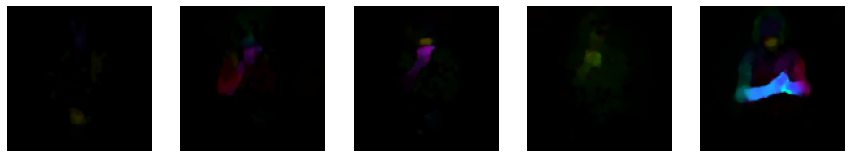

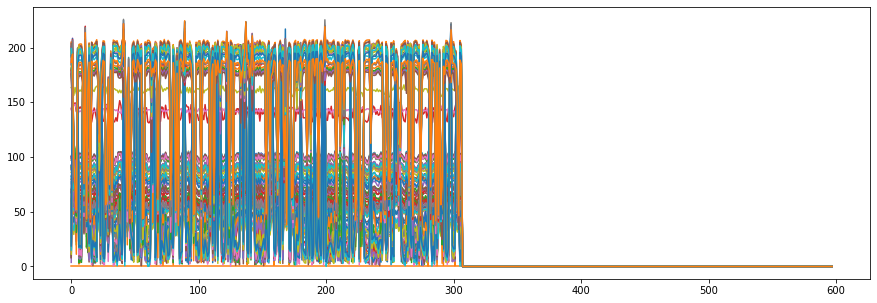

<Figure size 432x288 with 0 Axes>

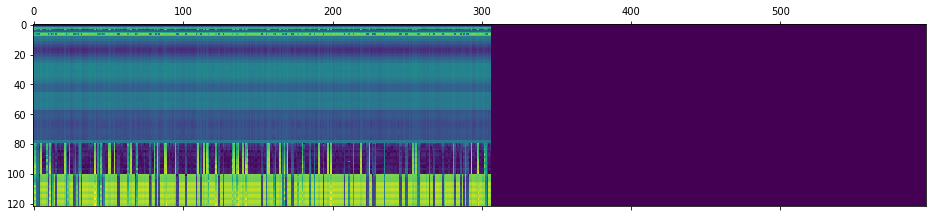

In [ ]:
for x, y in datasets_train.take(1):
    if args.inputShape[-1] == 9:
        print('Folder path {}'.format(x['path']))
        print('Dimensions:')
        print(x['encoder_input'].shape,x['encoder_input_2'].shape, x['decoder_input'].shape,y.shape)
        print('Sentence input: {}'.format(" ".join([vocab.index_word[i] for i in x['decoder_input'].numpy()[0]])))
        print('Sentence target: {}'.format(" ".join([vocab.index_word[i] for i in y.numpy()[0]])))
        slices = sorted(np.random.randint(1,args.inputShape[0],5))
        fig, axis = plt.subplots(3,5, figsize=(15,10))
        for r in range(axis.shape[0]):
            for c in range(axis.shape[1]):
                axis[r,c].imshow(x['encoder_input'][0,slices[c],:,:,r*3:(r*3)+3])
                axis[r,c].set_axis_off()
        plt.show() 
        fig2 = plt.figure(figsize=(15,5))
        plt.plot(x['encoder_input_2'][0,:,:])
        plt.show
        fig3 = plt.figure()
        plt.matshow(x['encoder_input_2'].numpy()[0,:,:].T)
        plt.show
        
    elif args.inputShape[-1] == 3:
        print('Folder path {}'.format(x['path']))
        print('Dimensions:')
        print(x['encoder_input'].shape,x['encoder_input_2'].shape, x['decoder_input'].shape,y.shape)
        print('Sentence input: {}'.format(" ".join([vocab.index_word[i] for i in x['decoder_input'].numpy()[0]])))
        print('Sentence target: {}'.format(" ".join([vocab.index_word[i] for i in y.numpy()[0]])))
        slices = sorted(np.random.randint(1,args.inputShape[0],5))
        fig, axis = plt.subplots(1,5, figsize=(15,5))
        axis = axis.flatten()
        for r in range(len(axis)):
            axis[r].imshow(x['encoder_input'][0,slices[r],:,:,:])
            axis[r].set_axis_off()
        plt.show() 
        fig2 = plt.figure(figsize=(15,5))
        plt.plot(x['encoder_input_2'][0,:,:])
        plt.show
        fig3 = plt.figure()
        plt.matshow(x['encoder_input_2'].numpy()[0,:,:].T)
        plt.show

### Model translation

#### Attention cnn filter module

In [ ]:
class SelfAttentionFilter(tf.keras.layers.Layer):
  def __init__(self, params, name='scaleDotSelfAttentionFilter'):
    super(SelfAttentionFilter, self).__init__(name=name)
    # layers
    #self.params = params
    self.wq = tf.keras.layers.Dense(units=params.selfUnits, activation='linear', use_bias=False, name='WqSelf3DcnnTAtt')
    self.wk = tf.keras.layers.Dense(units=params.selfUnits, activation='linear', use_bias=False, name='WkSelf3DcnnTAtt')
    
  def call(self, volume):
    b, t, h, w, f = volume.shape
    volume = tf.keras.layers.Reshape((t, h*w, f))(volume)
    volume_rt = tf.transpose(volume, perm=[0, 3, 1, 2])
    query = self.wq(volume_rt)
    keys = self.wk(volume_rt) 

    # scaled_attention.shape == (batch_size, t, units)
    # attention_weights.shape == (batch_size, t, t)
    matmul_qk = tf.matmul(query, keys, transpose_b=True)
    # scale matmul_qk
    dk = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_attention_logits =  tf.math.divide(matmul_qk, tf.math.sqrt(dk))
    
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

    #context_volume = tf.matmul(attention_weights, volume_rt)
    repeat_volume = tf.tile(volume_rt, [1,1,1,t])
    
    volume_rt_reshape = tf.keras.layers.Reshape((f,t,t,h*w))(repeat_volume)
    
    context_volume = tf.reduce_sum(
                            tf.multiply(
                                volume_rt_reshape,
                                tf.expand_dims(attention_weights, axis=-1), 
                            ),
                        axis=-2)
    
    context_volume = tf.transpose(context_volume, perm=[0, 2, 3, 1])
    context_volume = tf.keras.layers.Reshape((t, h, w, f))(context_volume)
    
    return context_volume, attention_weights

  def model(self):
    inputs = tf.keras.Input((56,56,56,64), batch_size = 1)
    return tf.keras.Model(inputs=inputs, outputs=self.call(inputs), name=self.name)  


In [ ]:
cnnAttention = SelfAttentionFilter(args)

In [ ]:
cnnAttention.model().summary()

Model: "scaleDotSelfAttentionFilter"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 56, 56, 56, 64) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (1, 56, 3136, 64)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Transpose (TensorFl [(1, 64, 56, 3136)]  0           reshape[0][0]                    
__________________________________________________________________________________________________
WkSelf3DcnnTAtt (Dense)         (1, 64, 56, 64)      200704      tf_op_layer_Transpose[0][0]      
________________________________________________________________________

#### Reduce features (Inception fashion)

In [ ]:
class Reducer(tf.keras.layers.Layer):
    def __init__(self, params, name='Reducer'):
        super(Reducer, self).__init__(name=name)
        # layers
        self.cnn1 = tf.keras.layers.Conv3D(filters=1, kernel_size=3, padding="same", activation="relu",
                              name='conv3d_3x3')
        self.cnn2 = tf.keras.layers.Conv3D(filters=1, kernel_size=5, padding="same", activation="relu",
                              name='conv3d_5x5')
        self.cnn3 = tf.keras.layers.Conv3D(filters=1, kernel_size=7, padding="same", activation="relu",
                              name='conv3d_7x7')
        self.concat = tf.keras.layers.Concatenate(axis=-1, name="concat_features")
        self.cnn4 = tf.keras.layers.Conv3D(filters=1, kernel_size=1, padding="same", activation="relu",
                              name='conv3d_1x1')
        self.reshape = tf.keras.layers.Reshape(target_shape=[28,28*28], name='reshape')
        self.dense = tf.keras.layers.Dense(params.denseUnits, name='dense_512')
    
    def call(self, volume):
        x1 = self.cnn1(volume)
        x2 = self.cnn2(volume)
        x3 = self.cnn3(volume)
        x = self.concat([x1,x2,x3])
        x = self.cnn4(x)
        x = self.reshape(x)
        x = self.dense(x)
    
        return x

    def model(self):
        inputs = tf.keras.Input((28, 28, 28, 64), batch_size = 1)
        return tf.keras.Model(inputs=inputs, outputs=self.call(inputs), name=self.name)  

In [ ]:
reducer = Reducer(args)
reducer.model().summary()

Model: "Reducer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1, 28, 28, 28, 64) 0                                            
__________________________________________________________________________________________________
conv3d_3x3 (Conv3D)             (1, 28, 28, 28, 1)   1729        input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_5x5 (Conv3D)             (1, 28, 28, 28, 1)   8001        input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_7x7 (Conv3D)             (1, 28, 28, 28, 1)   21953       input_2[0][0]                    
____________________________________________________________________________________________

### Encoder - Decoder model

In [ ]:
def reset_tf_keras():
    import gc
    # Reset Keras Session
    tf.keras.backend.clear_session()
    print(gc.collect())
reset_tf_keras()    

0


#### Encoder network

In [ ]:
#@title LTC Network for feature extractor
class EncoderNetwork(tf.keras.Model):
  def __init__(self, params, name='EncoderNetwork'):
    super(EncoderNetwork, self).__init__(name=name)
    # params
    self.params = params
    # architectur for openpose stream
    self.masker = tf.keras.layers.Masking(0.0)
    self.reducer = Reducer(params, name='reducer_512')
    self.rnn1 = tf.keras.layers.GRU(params.rnnUnits)
    # architecture for flow or RGB stream 
    # Block 1 ##################################################################
    self.conv1 = tf.keras.layers.Conv3D(filters=64, 
                                        kernel_size=3, 
                                        strides=(2,2,2), 
                                        padding="same", 
                                        activation="linear", 
                                        data_format='channels_last',
                                        kernel_regularizer=tf.keras.regularizers.l2(params.weight_decay),
                                        name='conv1a')
    self.bn1 = tf.keras.layers.BatchNormalization(axis=4, scale=False, name='bn1a')
    self.act1 = tf.keras.layers.Activation('relu', name='relu1a')
    self.max1 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2),
                                             strides=(2,2,2), 
                                             name='pool1a', 
                                             data_format='channels_last')
    self.cnnself1 = SelfAttentionFilter(params,name='selfattention1a')
    # Block 2 ##################################################################
    self.conv2 = tf.keras.layers.Conv3D(filters=128, 
                        kernel_size=(3,3,3), 
                        strides=(1,1,1), 
                        kernel_regularizer=tf.keras.regularizers.l2(params.weight_decay),
                        data_format='channels_last', 
                        padding="same",
                        name='conv2a')
    self.bn2 = tf.keras.layers.BatchNormalization(axis=4, scale=False, name='bn2a')
    self.act2 = tf.keras.layers.Activation('relu', name='relu2a')
    self.max2 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2),
                                             strides=(2,2,2), 
                                             name='pool2a',
                                             data_format='channels_last')
    self.cnnself2 = SelfAttentionFilter(params,name='selfattention2a')
    # Block 3 ##################################################################
    self.conv3 = tf.keras.layers.Conv3D(filters=256, 
                        kernel_size=(3,3,3), 
                        strides=(1,1,1), 
                        kernel_regularizer=tf.keras.regularizers.l2(params.weight_decay),
                        data_format='channels_last', 
                        padding="same",
                        name='conv3a')
    self.bn3 = tf.keras.layers.BatchNormalization(axis=4, scale=False, name='bn3a') 
    self.act3 = tf.keras.layers.Activation('relu', name='relu3a')
    self.max3 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2),
                                             strides=(2,2,2), 
                                             name='pool3a',
                                             data_format='channels_last')  
    self.cnnself3 = SelfAttentionFilter(params,name='selfattention3a') 
    # Block 4 ##################################################################
    self.conv4 = tf.keras.layers.Conv3D(filters=256, 
                        kernel_size=(3,3,3), 
                        strides=(1,1,1), 
                        kernel_regularizer=tf.keras.regularizers.l2(params.weight_decay),
                        data_format='channels_last', 
                        padding="same",
                        name='conv3b')
    self.bn4 = tf.keras.layers.BatchNormalization(axis=4, scale=False, name='bn3b')
    self.act4 = tf.keras.layers.Activation('relu', name='relu3b')
    self.max4 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2),
                                             strides=(2,2,2), 
                                             name='pool3b',
                                             data_format='channels_last') 
    self.cnnself4 = SelfAttentionFilter(params,name='selfattention3b') 
    # Block 5 ##################################################################
    self.conv5 = tf.keras.layers.Conv3D(filters=512, 
                        kernel_size=(3,3,3), 
                        strides=(1,1,1), 
                        kernel_regularizer=tf.keras.regularizers.l2(params.weight_decay),
                        data_format='channels_last', 
                        padding="same",
                        name='conv4a')
    self.bn5 = tf.keras.layers.BatchNormalization(axis=4, scale=False, name='bn4a')
    self.act5 = tf.keras.layers.Activation('relu', name='relu4a')
    self.max5 = tf.keras.layers.MaxPooling3D(pool_size=(2,2,2),
                                             strides=(2,2,2), 
                                             name='pool4a',
                                             data_format='channels_last')     
    
    
    self.reshape = tf.keras.layers.Flatten()
    self.concat = tf.keras.layers.Concatenate(axis=-1)                                       
    self.dense = tf.keras.layers.Dense(params.denseUnits, name='dense_encoder')
    self.dropout = tf.keras.layers.Dropout(params.dropout, name='dropout_final')

        
  def call(self, input1, input2):
    x1 = self.conv1(input1)
    x1 = self.bn1(x1)
    x1 = self.act1(x1)   
    x1 = self.max1(x1)
    x1, _ = self.cnnself1(x1)
    features = self.reducer(x1)
    x1 = self.conv2(x1)
    x1 = self.bn2(x1)
    x1 = self.act2(x1)
    x1 = self.max2(x1)
    x1, _ = self.cnnself2(x1)
    x1 = self.conv3(x1)
    x1 = self.bn3(x1)
    x1 = self.act3(x1)
    x1 = self.max3(x1)
    x1, _ = self.cnnself3(x1)
    x1 = self.conv4(x1)
    x1 = self.bn4(x1)
    x1 = self.act4(x1)
    x1 = self.max4(x1)
    x1, _ = self.cnnself4(x1)
    x1 = self.conv5(x1)
    x1 = self.bn5(x1)
    x1 = self.act5(x1)
    x1 = self.max5(x1) 
    x1 = self.reshape(x1)                                       
    # processing open pose                                        
    x2 = self.masker(input2)
    x2 = self.rnn1(x2)                                        
    # concat embeddings
    x = self.concat([x1,x2])
    x = self.dense(x)                                       
    x = self.dropout(x)

    return x, features 

  def model(self):
      input1 = tf.keras.Input((self.params.inputShape), batch_size = 1)
      input2 = tf.keras.Input((self.params.maxframes,self.params.kpoints), batch_size = 1)
      return tf.keras.Model(inputs=[input1,input2], outputs=self.call(input1, input2), name=self.name)

In [ ]:
encoder = EncoderNetwork(args)

In [ ]:
encoder.model().summary()

Model: "EncoderNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 112, 112, 112,  0                                            
__________________________________________________________________________________________________
conv1a (Conv3D)                 (1, 56, 56, 56, 64)  5248        input_1[0][0]                    
__________________________________________________________________________________________________
bn1a (BatchNormalization)       (1, 56, 56, 56, 64)  192         conv1a[0][0]                     
__________________________________________________________________________________________________
relu1a (Activation)             (1, 56, 56, 56, 64)  0           bn1a[0][0]                       
_____________________________________________________________________________________

#### Load pre-trained weights

In [ ]:
# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'ucf1_rgb100_fromC3D_71' : 'https://lsh.paris.inria.fr/LTC/ucf1_rgb100_fromC3D_71.t7',
    'ucf3_rgb100_fromC3D_71' : 'https://lsh.paris.inria.fr/LTC/ucf3_rgb100_fromC3D_71.t7',
    'ucf2_rgb100_fromC3D_71' : 'https://lsh.paris.inria.fr/LTC/ucf2_rgb100_fromC3D_71.t7'}

In [ ]:
def load_weights(model, pre_trained_model):
    from collections import defaultdict
    weights_pretrained = defaultdict(list)
    for layer_index in range(len(pre_trained_model)): 
        if  pre_trained_model[layer_index].name != None:
            layer_name = pre_trained_model[layer_index].name.decode("utf-8")
            if 'conv' == str(layer_name[:4]):
                kernel_weight = np.moveaxis(np.r_[pre_trained_model[layer_index].weight], (0,1),(4,3))
                bias = np.r_[pre_trained_model[layer_index].bias]
                weights_pretrained[layer_name].append(kernel_weight)
                weights_pretrained[layer_name].append(bias)
    # set weights
    layers = set(list(weights_pretrained.keys()))
    for i,layer in enumerate(model.layers):
        if layer.name != 'input_1' and layer.name in layers:
            #print('Setting weights for layer {}'.format(layer.name))
            model.layers[i].set_weights(weights_pretrained[layer.name])  

    return model    

In [ ]:
if args.inputShape[-1] == 3 and args.weights in ['ucf1_rgb100_fromC3D_71', 'ucf3_rgb100_fromC3D_71', 'ucf2_rgb100_fromC3D_71']:
    print('loading weights')
    model_name = args.weights+'.t7'
    weights_url = WEIGHTS_PATH_NO_TOP[args.weights]
    # from web
    downloaded_weights_path = tf.keras.utils.get_file(model_name, weights_url, cache_subdir='models')
    pre_trained_model = torchfile.load(downloaded_weights_path).modules
    # set weights
    encoder = load_weights(encoder, pre_trained_model) 

# layer freezing
if args.layer2freeze != None:
    for layer in encoder.layers[:args.layer2freeze]:
        layer.trainable = False
    for layer in encoder.layers[args.layer2freeze:]:
        layer.trainable = True

loading weights


#### Decoder Nework

In [ ]:
class DecoderNetwork(tf.keras.Model):
    def __init__(self, params, name='DecoderNetwork'):
        super(DecoderNetwork, self).__init__(name=name)
        self.params = params
        self.decoder_embedding = tf.keras.layers.Embedding(input_dim=params.vocab_size+1,
                                                           output_dim=params.unitsEmbedding) 
        self.dense_layer = tf.keras.layers.Dense(params.vocab_size)
        self.decoder_rnncell = tf.keras.layers.GRUCell(params.rnnUnits)
        # for stacked rnn cells
        #rnn_cells = [tf.keras.layers.GRUCell(params.rnnUnits) for _ in range(3)]
        #self.decoder_rnncell = tf.keras.layers.StackedRNNCells(rnn_cells)

        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = self.build_attention_mechanism(params.denseUnits,
                                                                  None,
                                                                  params.batchSize*[28])
        self.rnn_cell =  self.build_rnn_cell(params.batchSize)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler,
                                                output_layer=self.dense_layer)

    def build_attention_mechanism(self, units, memory, memory_sequence_length):
        return tfa.seq2seq.LuongAttention(units, memory = memory,memory_sequence_length=memory_sequence_length 
                                          )#
        #return tfa.seq2seq.BahdanauAttention(units, memory = memory, memory_sequence_length=memory_sequence_length)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size ):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism,
                                                attention_layer_size=self.params.denseUnits)
        return rnn_cell
    
    def build_decoder_initial_state(self, batch_size, encoder_state,Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 
        
        return decoder_initial_state  

In [ ]:
decoder = DecoderNetwork(args)

### Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(args.lr)

In [ ]:
def loss_function(y_pred, y):
   
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss

@tf.function
def train_step(enc_input_1, enc_input_2, dec_input, dec_output):
    #initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        #[last step activations] of encoder passed as input to decoder Network
        a_tx, a = encoder(enc_input_1, enc_input_2)
        #print('encoder final state {}'.format(a_tx.shape), type(a_tx))
        #print('encoder features {}'.format(a.shape), type(a))
        # Decoder Embeddings
        decoder_emb_inp = decoder.decoder_embedding(dec_input)
        #print('Decoder embedding {}'.format(decoder_emb_inp.shape), type(decoder_emb_inp))
        #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
        decoder.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoder.build_decoder_initial_state(args.batchSize,
                                                                           encoder_state=a_tx,
                                                                           Dtype=tf.float32)
        
        #print('ATTENTION WRAP')
        #print('Decoder cell state {}'.format(decoder_initial_state.cell_state.shape), type(decoder_initial_state.cell_state))
        #print('Decoder attention {}'.format(decoder_initial_state.attention.shape), type(decoder_initial_state.attention))
        #print('Decoder attention state {}'.format(decoder_initial_state.attention_state.shape), type(decoder_initial_state.attention_state))
        #print('Decoder alignments {}'.format(decoder_initial_state.alignments.shape), type(decoder_initial_state.alignments))
        #print('Decoder alignment history {}'.format(len(decoder_initial_state.alignment_history)), type(decoder_initial_state.alignment_history))
        
        #BasicDecoderOutput        
        outputs, _, _ = decoder.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=args.batchSize*[args.ty-1])
        logits = outputs.rnn_output
        #print('RNN output {}'.format(logits.shape), type(logits))
        #print('Sample id {}'.format(outputs.sample_id.shape), type(outputs.sample_id))
        #print('Decoder target {}'.format(dec_output.shape), type(dec_output))
        #Calculate loss
        loss = loss_function(logits, dec_output)

    #Returns the list of all layer variables / weights.
    variables = encoder.trainable_variables + decoder.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    #grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

In [ ]:
# checkpoint manager
checkpoint_path = "results/checkpoints/train" 
os.makedirs(checkpoint_path, exist_ok = True)

checkpoint_dir = os.path.dirname(checkpoint_path)

ckpt = tf.train.Checkpoint(step=tf.Variable(1),
                           encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)  

# load latest check
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Epoch ', start_epoch)
    print('Latest check ..', ckpt_manager.latest_checkpoint)

Epoch  10
Latest check .. results/checkpoints/train/ckpt-10


In [ ]:
#tf.keras.backend.set_floatx('float64')

# training
for i in range(start_epoch+1, args.epochs+1):
    total_loss = 0.0
    ckpt.step.assign_add(1)
    for (batch, (x,y)) in enumerate(datasets_train):
        enc_input_1 = x['encoder_input']
        enc_input_2 = x['encoder_input_2']
        dec_input = x['decoder_input']
        dec_output = y 
        batch_loss = train_step(enc_input_1, enc_input_2, dec_input, dec_output)
        total_loss += batch_loss
        if (batch+1)%1 == 0:
            print("total loss: {} batch_loss: {} epoch {} batch {} ".format(total_loss.numpy()/i, batch_loss.numpy(), i, batch+1))
    if i%2 == 0:
        save_path = ckpt_manager.save()
        print("Checkpoint saved {}: {}".format(int(ckpt.step), save_path))
# save the entire final models and weights
encoder.save_weights(checkpoint_path+'/final_encoder_model_weights.h5')
decoder.save_weights(checkpoint_path+'/final_decoder_model_weights.h5')

## Greedy and Beam search inference

### INFERENCE with greedy sampling:

In [ ]:
# TODO: Acomodar para soportar varias muestras, falta solo en la parte de mostrar las frases
inference_batchSize = 1
start_tokens = tf.fill([inference_batchSize],vocab.word_index['<s>'])
end_token = vocab.word_index['</s>'] 

file_translations = open('results/translations.txt',"a+")
file_references = open('results/references.txt',"a+")

for (batch, (x,y)) in enumerate(datasets_test):
    enc_input_1 = x['encoder_input']
    enc_input_2 = x['encoder_input_2']
    dec_input = x['decoder_input']
    dec_output = y    
    target = y.numpy().ravel()
    sentence_target = [vocab.index_word[target[i]] for i in range(0,len(target)) if target[i]!=0]
    reference = " ".join(sentence_target)
    print('\nReference: ', reference)     
    greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
    a_tx, a = encoder(enc_input_1, enc_input_2)
    decoder_input = tf.expand_dims([vocab.word_index['<s>']]*inference_batchSize,1)
    decoder_emb_input = decoder.decoder_embedding(decoder_input)
    decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder.rnn_cell, sampler=greedy_sampler,
                                                output_layer=decoder.dense_layer)
    decoder.attention_mechanism.setup_memory(a)
    decoder_initial_state = decoder.build_decoder_initial_state(inference_batchSize,
                                                                encoder_state=a_tx,
                                                                Dtype=tf.float32)
    decoder_embedding_matrix = decoder.decoder_embedding.variables[0] 
    (first_finished, first_inputs, first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                                                                              start_tokens=start_tokens,
                                                                              end_token=end_token,
                                                                              initial_state = decoder_initial_state) 
    inputs = first_inputs
    state = first_state  
    predictions = np.empty((inference_batchSize,0), dtype = np.int32)
    maximum_iterations = args.ty
    for j in tf.range(maximum_iterations):
        outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
        inputs = next_inputs
        state = next_state
        outputs = np.expand_dims(outputs.sample_id,axis = -1)
        predictions = np.append(predictions, outputs, axis = -1)
        if vocab.index_word[outputs[0][0]]=='</s>':
            break 
    # translation ouput
    sentence_translated = [vocab.index_word[predictions[0,i]] for i in range(0,predictions.shape[-1])]#if target[i]!=0
    translation = " ".join(sentence_translated) 
    print('\nTranslation: ', translation)   
    ## Guardar las predicciones
    file_references.write(reference.replace('</s>',''))
    file_references.write('\n')
    file_translations.write(translation.replace('</s>',''))
    file_translations.write('\n')
file_translations.close()
file_references.close()
# remove used gpu
reset_tf_keras()   


Reference:  ¿ tú cómo estás ? </s>

Translation:  ¿ no a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  ella va a traer un perro al colegio mañana . </s>

Translation:  ¿ no a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  tú irás a trabajar . </s>

Translation:  ¿ tú a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  yo estoy cansado . </s>

Translation:  ¿ tú a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  mary le cuenta a juan que compró una casa . </s>

Translation:  ¿ no ? </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  tu hermano tiene hambre . </s>

Translation:  ¿ no a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  el libro que juan compró ayer . </s>

Translation:  ¿ no a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Reference:  la mamá de juan es profesora . </s>

Translation:  ¿ no a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>

Ref

### INFERENCE with beam search sampling:

In [ ]:
class MultiCellRNN(tf.keras.layers.Layer):

    def __init__(self, num_layers, num_units, **kwargs):
        super().__init__(**kwargs)

        self.cells = [
            tf.keras.layers.LSTMCell(
                num_units,
            )
            for _ in range(num_layers)
        ]

        self.cell = tf.keras.layers.StackedRNNCells(
            self.cells,
        )

    def call(self, x, state, **kwargs):

        state = tf.split(state, [128, 128, 128, 128], 1)
        x, state = self.cell(x, ([state[0], state[1]], [state[2], state[3]]))
        state = tf.concat([state[0][0], state[0][1], state[1][0], state[1][1]], 1)

        return x, state

In [ ]:
# TODO: Acomodar para soportar varias muestras, falta solo en la parte de mostrar las frases
inference_batchSize = 1
beam_width = 5
start_tokens = tf.fill([inference_batchSize],vocab.word_index['<s>'])
end_token = vocab.word_index['</s>'] 

for (batch, (x,y)) in enumerate(datasets_test.take(10)):
    enc_input_1 = x['encoder_input']
    enc_input_2 = x['encoder_input_2']
    dec_input = x['decoder_input']
    dec_output = y    
    target = y.numpy().ravel()
    sentence_target = [vocab.index_word[target[i]] for i in range(0,len(target)) if target[i]!=0]
    reference = " ".join(sentence_target)
    print('\nReference: ', reference) 
    # a_tx --> Last final representation | a --> Features reduced
    a_tx, a = encoder(enc_input_1, enc_input_2)
    # tile encoder outputs 
    encoder_memory = tfa.seq2seq.tile_batch(a, multiplier=beam_width)
    decoder.attention_mechanism.setup_memory(encoder_memory)
    # encoder final state
    encoder_state = tfa.seq2seq.tile_batch(a_tx, multiplier=beam_width)
    # decoder initial state
    decoder_initial_state = decoder.build_decoder_initial_state(inference_batchSize*beam_width,
                                                                encoder_state=encoder_state,
                                                                Dtype=tf.float32)
    # Decoder input
    decoder_input = tf.expand_dims([vocab.word_index['<s>']]*inference_batchSize,1)
    decoder_emb_input = decoder.decoder_embedding(decoder_input)
    # beam search decoder inference
    decoder_instance = tfa.seq2seq.BeamSearchDecoder(cell=decoder.rnn_cell, beam_width=beam_width,
                                                output_layer=decoder.dense_layer,
                                                    output_time_major=True,
                                                    length_penalty_weight=0.6,
                                                    coverage_penalty_weight=0.2)
    
    # decoder instance
    decoder_embedding_matrix = decoder.decoder_embedding.variables[0] 
    (first_finished, first_inputs, first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                                                                              start_tokens=start_tokens,
                                                                              end_token=end_token,
                                                                              initial_state = decoder_initial_state) 
    inputs = first_inputs
    state = first_state  
    predictions = np.empty((inference_batchSize, beam_width, 1), dtype = np.int32)
    scores = np.empty((inference_batchSize, beam_width, 1), dtype = np.int32)
    maximum_iterations = args.ty
    for j in tf.range(maximum_iterations):
        outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
        #print(outputs, finished)
        inputs = next_inputs
        state = next_state
        outputs_ids = outputs.predicted_ids
        outputs_parent_ids = outputs.parent_ids
        outputs_scores = outputs.scores 
        predictions = np.append(predictions, np.expand_dims(outputs_ids, axis=-1), axis = -1)
        scores = np.append(scores, np.expand_dims(outputs_scores, axis=-1), axis = -1)

    # For all batches
    high = -np.inf
    for i in range(len(predictions)):
        print('Prediction {}'.format(i+1))
        output_beams_per_sample = predictions[i,:,:]
        scores_beams_per_samples = scores[i,:,:]
        for beam, score in zip(output_beams_per_sample, scores_beams_per_samples):
            sum_ = 0
            prod_ = 1
            translation = []
            for k,b in enumerate(beam):
                if b in list(range(0, args.vocab_size)):
                    if vocab.index_word[b]=='</s>':
                        break
                    else:
                        sum_ = sum_ + np.exp(score[k])
                        prod_ = prod_ * score[k]
                        translation.append(vocab.index_word[b])

            print("--> Sum of probabilities {} product of probabilities {}".format(sum_, prod_))
            print('--> Translation: {}'.format(" ".join(translation)))      


Reference:  ¿ tú cómo estás ? </s>
Prediction 1
--> Sum of probabilities inf product of probabilities -4441047286.224307
--> Translation: ¿ ¿ no a
--> Sum of probabilities 1.1695784393576005 product of probabilities 0.0
--> Translation: no mary tú ? .
--> Sum of probabilities inf product of probabilities -55657971577.6436
--> Translation: a las juan a
--> Sum of probabilities 0 product of probabilities 1
--> Translation: 
--> Sum of probabilities 0 product of probabilities 1
--> Translation: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp



Reference:  ella va a traer un perro al colegio mañana . </s>
Prediction 1
--> Sum of probabilities 0.7407560167078588 product of probabilities -4.41512737830577
--> Translation: ¿ no a
--> Sum of probabilities 485165195.6201068 product of probabilities 2463.2645251315535
--> Translation: <pad> mary tú a .
--> Sum of probabilities 0.12495708521972075 product of probabilities 196.62345672736961
--> Translation: carlos juan ? ?
--> Sum of probabilities 20.189684490647164 product of probabilities 684.7893113942768
--> Translation: <pad> no a ? .
--> Sum of probabilities 20.175243925113072 product of probabilities 130241845346616.92
--> Translation: futuro las viaja . ? . estás . mes casa mes casa ? casa ?

Reference:  tú irás a trabajar . </s>
Prediction 1
--> Sum of probabilities inf product of probabilities -5177685594.076649
--> Translation: ¿ ¿ tú a
--> Sum of probabilities 1.1694833377757199 product of probabilities 0.0
--> Translation: no carlos no ? .
--> Sum of probabilities inf 

In [ ]:
predictions.shape

(1, 5, 15)

In [ ]:
for i in range(len(predictions)):
    print('Prediction {}'.format(i+1))
    output_beams_per_sample = predictions[i,:,:]
    scores_beams_per_samples = scores[i,:,:]
    for beam, score in zip(output_beams_per_sample, scores_beams_per_samples):
        sum_, prod_ = score.sum(), score.prod()
        print("--> Sum of probabilities {} product of probabilities {}".format(sum_, prod_))
        print('--> Translation: {}'.format(" ".join([vocab.index_word[w] for w in beam if w in list(range(0, args.vocab_size))])))   

Prediction 1
--> Sum of probabilities -128.23054081201553 product of probabilities 5224590669722.97
--> Translation: ¿ no a </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
--> Sum of probabilities -125.39176511764526 product of probabilities 276418808242876.25
--> Translation: <pad> mary tú . </s> . </s> casa </s> casa </s> casa </s> casa </s>
--> Sum of probabilities -142.84626960754395 product of probabilities 135764476329491.72
--> Translation: las juan ? . ? </s> . </s> . </s> . </s> . </s>
--> Sum of probabilities -148.85298657417297 product of probabilities 95808489303841.14
--> Translation: <pad> no a a </s> casa </s> ? </s> ? </s> mes </s> mes </s>
--> Sum of probabilities -152.4958212375641 product of probabilities 146995305113346.88
--> Translation: futuro carlos viaja . </s> estás . mes casa mes casa ? casa ? casa


## Visualization

In [ ]:
# translation ouput
sentence_translated = [vocab.index_word[predictions[0,i]] for i in range(0,predictions.shape[-1])]#if target[i]!=0
translation = " ".join(sentence_translated) 
print('\nTranslation: ', translation)  

In [ ]:
def video2text(dataset_valid, dataset_test, encoder_trained, decoder_trained, vocab, params, search='Greedy'):
    from collections import defaultdict
    import pickle
    import tensorflow as tf
    import numpy as np
    import os

    directory = params.dataset
  
    # Parent Directory path 
    parent_dir = params.path2save
  
    # Path 
    path_dir = os.path.join(parent_dir, directory) 
  
    # Create the directory 
    try: 
        os.makedirs(path_dir, exist_ok = True) 
        print("Directory '%s' created successfully" %directory) 
    except OSError as error: 
        print("Directory '%s' can not be created")     
    
    #datasets = [dataset_valid, dataset_test]
    datasets = [dataset_test]
    results = defaultdict(dict)

    index_word = vocab.index_word
    word_index = vocab.word_index
    
    for name, dataset in zip(['test'],datasets):
        counter_video = 1 
        file_translations = open(path_dir+'/translations.'+name,"a+")
        file_references = open(path_dir+'/references.'+name,"a+")
        for x, y in dataset:
            print('Video sign: {}'.format(counter_video))
            video = x['encoder_input']
            target = y.numpy().ravel()
            sentence_target = [index_word[target[i]] for i in range(0,len(target)) if target[i]!=0]
            reference = " ".join(sentence_target)
            print('\nReference: ', reference)     
            h1, c1, h2, c2, h3, c3, h4, c4, enc_outputs_high, self_att, w4, w5  = encoder_trained.predict(video) 
            word_input = np.zeros((1, 1))
            word_input[0, 0] = word_index['<s>']
            stop_condition = False
            decoded_sentence = list()
            temporal_weights = list()
            while not stop_condition:
                prediction, h1, c1, h2, c2, h3, c3, h4, c4, att_w_temporal = decoder_trained.predict([enc_outputs_high, 
                                                                                      h1, c1, 
                                                                                      h2, c2,
                                                                                      h3, c3,
                                                                                      h4, c4,
                                                                                      word_input])
                #predicted_id = tf.random.categorical(tf.squeeze(prediction, axis=1), 1)[0][0].numpy()
                #predicted_id = tf.math.argmax(prediction).numpy()
                predicted_id = np.argmax(prediction)
                temporal_weights.append(att_w_temporal)
                word = index_word[predicted_id]
                decoded_sentence.append(word)
                if (word == '</s>' or len(decoded_sentence) > params.ty):
                    stop_condition = True
                if search=="Greedy":
                        word_input = np.zeros((1, 1))
                        word_input[0, 0] = predicted_id

            file_references.write(reference.replace('</s>',''))
            file_references.write('\n')
            translate = " ".join(decoded_sentence)
            file_translations.write(translate.replace('</s>',''))
            file_translations.write('\n')
            print('Translation: {}'.format(translate))
            print('\n')
            results[name][counter_video] = [decoded_sentence, sentence_target, temporal_weights, w4, w5, self_att]
            decoded_sentence = list()
            counter_video = counter_video + 1
        file_translations.close()
        file_references.close()
    with open(path_dir+'/'+params.name+'.pkl', 'wb') as file:
        pickle.dump(results, file)  
    
    #return results

In [ ]:
#counter = count_frames(path=args.videos_path, folder=args.type[:-1]) 
#print('Max number of frames: {} Min: {} Mean: {} std: {}'.format(max(counter), min(counter), np.mean(counter), np.std(counter))) 

In [ ]:
print('Vocab len: {} and table: {}'.format(len(vocab.index_word), vocab.index_word))

In [ ]:
print('Max len of tokens: {}'.format(preprocessed_sentences[0].shape[1]))

In [ ]:
#@title train helpers { display-mode: "form" }

# loss functions

def SparseCategoricalCrossentropy_mask():
  def loss(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
  return loss

# learning rate decay
def step_decay(epoch):
    initial_lrate = args.lr
    drop = args.decay
    epochs_drop = args.nIters
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

# metrics 
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy', dtype=tf.float32) 

# optimizer
optimizer = tf.keras.optimizers.Adam(lr=args.lr, clipnorm=1.,clipvalue=5, amsgrad=True, decay=0.0,)
loss = SparseCategoricalCrossentropy_mask()
# checkpoint manager
#checkpoint_path="training/weights-improvement-{epoch:04d}-{val_train_accuracy:.2f}.ckpt"
checkpoint_path="training/weights-improvement-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, 
                                                     save_best_only=False, mode='auto', save_weights_only=True, save_freq='epoch') 
callbacks_list = [lrate, cp_callback] # cp_callback #monitor='val_acc'

In [ ]:
!ls {checkpoint_dir}


In [ ]:
datasets_train, generators_train = build_datasets(pre_dataset, indexes, args, set_='train')
datasets_test, generators_test = build_datasets(pre_dataset, indexes, args, set_='test')

In [ ]:
tf.keras.backend.clear_session()
modelSLT.compile(optimizer=optimizer, loss=loss, metrics=train_accuracy)

In [ ]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#latest

In [ ]:
# Load the previously saved weights
#modelSLT.load_weights(latest)

In [ ]:
modelSLT.save_weights(checkpoint_path.format(epoch=0))
history = modelSLT.fit(datasets_train,
                    epochs=args.epochs,
                    callbacks=callbacks_list,
                    verbose=1,
                    )
#validation_data=datasets_test,
#validation_steps=len(indexes[1])-1

In [ ]:
plt.title('Loss vs Val loss')
plt.plot(history.history['loss'], label='train loss')
#plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [ ]:
plt.title('Acc vs Val acc')
plt.plot(history.history['train_accuracy'], label='train acc')
#plt.plot(history.history['val_train_accuracy'], label='val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
#@title generating translations { display-mode: "form" }
 
def video2text(dataset_valid, dataset_test, encoder_trained, decoder_trained, vocab, params, search='Greedy'):
    from collections import defaultdict
    import pickle
    import tensorflow as tf
    import numpy as np
    import os

    directory = params.dataset
  
    # Parent Directory path 
    parent_dir = params.path2save
  
    # Path 
    path_dir = os.path.join(parent_dir, directory) 
  
    # Create the directory 
    try: 
        os.makedirs(path_dir, exist_ok = True) 
        print("Directory '%s' created successfully" %directory) 
    except OSError as error: 
        print("Directory '%s' can not be created")     
    
    #datasets = [dataset_valid, dataset_test]
    datasets = [dataset_test]
    results = defaultdict(dict)

    index_word = vocab.index_word
    word_index = vocab.word_index
    
    for name, dataset in zip(['test'],datasets):
        counter_video = 1 
        file_translations = open(path_dir+'/translations.'+name,"a+")
        file_references = open(path_dir+'/references.'+name,"a+")
        for x, y in dataset:
            print('Video sign: {}'.format(counter_video))
            video = x['encoder_input']
            target = y.numpy().ravel()
            sentence_target = [index_word[target[i]] for i in range(0,len(target)) if target[i]!=0]
            reference = " ".join(sentence_target)
            print('\nReference: ', reference)     
            h1, c1, h2, c2, h3, c3, h4, c4, enc_outputs_high, self_att, w4, w5  = encoder_trained.predict(video) 
            word_input = np.zeros((1, 1))
            word_input[0, 0] = word_index['<s>']
            stop_condition = False
            decoded_sentence = list()
            temporal_weights = list()
            while not stop_condition:
                prediction, h1, c1, h2, c2, h3, c3, h4, c4, att_w_temporal = decoder_trained.predict([enc_outputs_high, 
                                                                                      h1, c1, 
                                                                                      h2, c2,
                                                                                      h3, c3,
                                                                                      h4, c4,
                                                                                      word_input])
                #predicted_id = tf.random.categorical(tf.squeeze(prediction, axis=1), 1)[0][0].numpy()
                #predicted_id = tf.math.argmax(prediction).numpy()
                predicted_id = np.argmax(prediction)
                temporal_weights.append(att_w_temporal)
                word = index_word[predicted_id]
                decoded_sentence.append(word)
                if (word == '</s>' or len(decoded_sentence) > params.ty):
                    stop_condition = True
                if search=="Greedy":
                        word_input = np.zeros((1, 1))
                        word_input[0, 0] = predicted_id

            file_references.write(reference.replace('</s>',''))
            file_references.write('\n')
            translate = " ".join(decoded_sentence)
            file_translations.write(translate.replace('</s>',''))
            file_translations.write('\n')
            print('Translation: {}'.format(translate))
            print('\n')
            results[name][counter_video] = [decoded_sentence, sentence_target, temporal_weights, w4, w5, self_att]
            decoded_sentence = list()
            counter_video = counter_video + 1
        file_translations.close()
        file_references.close()
    with open(path_dir+'/'+params.name+'.pkl', 'wb') as file:
        pickle.dump(results, file)  
    
    #return results




def plot_dataset(dataset, ncols=6, nrows=6):
    ncols, nrows = ncols, nrows
    
    for i, triple in enumerate(dataset):
      fig = plt.gcf()
      fig.set_size_inches(ncols*3, nrows*3)
      if i in [0,15,20,30,40,70,100,150,300,350,400,450,500, 520, 550]:
          video = triple[0]['encoder_input'].numpy()
          step_images = int(video.shape[1]/ncols+1)
          for enum, j in enumerate(range(0, video.shape[1], step_images)): 
              sp = plt.subplot(nrows, ncols, enum + 1)
              sp.axis('Off');
              plt.imshow(video[0,j,:,:,:]);
          #print("Source: ", " ".join([vocab.index_word[j] for j in triple[0]['decoder_input'].numpy()[0,:]]))
          print("Target: ", " ".join([vocab.index_word[np.argmax(triple[1].numpy()[0,h,:])] for h in range(args.ty)]))
          plt.show();
      else:
          continue 
            
def predict_sentence(x, y, params, search='Greedy'):
    video = x['encoder_input']
    target = y.numpy().ravel()
    sentence_target = [index_word[target[i]] for i in range(0,len(target)) if target[i]!=0]
    reference = " ".join(sentence_target)
    #print('\nReference: ', reference)     
    h1, c1, h2, c2, h3, c3, h4, c4, enc_outputs_high, self_att, w4, w5  = encoder_model.predict(video) 
    word_input = np.zeros((1, 1))
    word_input[0, 0] = word_index['<s>']
    stop_condition = False
    decoded_sentence = list()
    temporal_weights = list()
    while not stop_condition:
        prediction, h1, c1, h2, c2, h3, c3, h4, c4, att_w_temporal = decoder_model.predict([enc_outputs_high, 
                                                                              h1, c1, 
                                                                              h2, c2,
                                                                              h3, c3,
                                                                              h4, c4,
                                                                              word_input])
        #predicted_id = tf.random.categorical(tf.squeeze(prediction, axis=1), 1)[0][0].numpy()
        #predicted_id = tf.math.argmax(prediction).numpy()
        predicted_id = np.argmax(prediction)
        temporal_weights.append(att_w_temporal)
        word = index_word[predicted_id]
        decoded_sentence.append(word)
        if (word == '</s>' or len(decoded_sentence) > params.ty):
            stop_condition = True
        if search=="Greedy":
                word_input = np.zeros((1, 1))
                word_input[0, 0] = predicted_id

        translate = " ".join(decoded_sentence)  
    return reference, translate, temporal_weights            

In [ ]:
video2text(datasets_test, datasets_test, encoder_model, decoder_model, vocab, args, search='Greedy')

In [ ]:
modelSLT.save('training/model') 

## Visualizations

In [ ]:
from skimage.transform import resize 
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import random
import imageio
from tensorflow.keras.preprocessing.image import img_to_array, load_img
%config InlineBackend.figure_format="svg"
%matplotlib inline
import numpy as np
import random
import matplotlib

In [ ]:
layers_dict = {}
for j, layer in enumerate(modelSLT.layers[:]):
    layers_dict[layer.name] = (j,layer.output)
layers_dict    

In [ ]:
index_word = vocab.index_word
word_index = vocab.word_index
n = np.random.randint(1,5)
for dict_x, y in datasets_test.skip(n).take(1):
    x = dict_x['encoder_input']
    reference, translation, temporal_weights = predict_sentence(dict_x, y, params=args, search='Greedy')
    print('Reference: ', reference)
    for number_layer in [1, 3, 7, 11, 15, 20]:
        name_layer = modelSLT.layers[number_layer].name
        successive_outputs = modelSLT.layers[number_layer].output
        visualization_model = tf.keras.models.Model(inputs = encoder_model.input, 
                                                    outputs = successive_outputs)
        successive_feature_maps = visualization_model.predict(x)

        if 'LTC_sign_model' in name_layer:
            features = np.squeeze(successive_feature_maps[0])
            weights5 = np.squeeze(successive_feature_maps[1])
            weights6 = np.squeeze(successive_feature_maps[2])
            features_5_pre = np.squeeze(successive_feature_maps[3]) 
            features_5_post = np.squeeze(successive_feature_maps[4])
            print(np.mean(features_5_pre.ravel()))
            print(np.mean(features_5_post.ravel()))
            plt.imshow(features_5_pre[50,:,:,100])
            plt.show()
            plt.imshow(features_5_post[50,:,:,100])
            plt.show()
            
            
            
            #features_6_pre = np.squeeze(successive_feature_maps[5]) 
            #features_6_post = np.squeeze(successive_feature_maps[6]) 
            print('LTC weight matrix volumen 5')
            fig = plt.figure(figsize=(2,2))
            vol = weights5[:,:,:]

            # create the figura with 4 columns and 3 rows
            fig = plt.gcf()
            ncols, nrows = 8, 8
            fig.set_size_inches(ncols*2, nrows*1)

            for i, f in enumerate(np.random.randint(0, vol.shape[0], 64)):
              # Set up subplot; subplot indices start at 1
              sp = plt.subplot(nrows, ncols, i + 1)
              sp.axis('Off') # Don't show axes (or gridlines)
              img = vol[f,:,:] 
              #sp.set_title('Filter: {} dim: {}'.format(i,img.shape))
              plt.imshow(img, cmap=matplotlib.cm.get_cmap('hot_r'))

            plt.show()
            print('LTC weight matrix volumen 6')
            fig = plt.figure(figsize=(2,2))
            vol = weights6[:,:,:]

            # create the figura with 4 columns and 3 rows
            fig = plt.gcf()
            ncols, nrows = 8, 8
            fig.set_size_inches(ncols*2, nrows*1)

            for i in range(ncols*nrows):
              # Set up subplot; subplot indices start at 1
              sp = plt.subplot(nrows, ncols, i + 1)
              sp.axis('Off') # Don't show axes (or gridlines)
              img = vol[i,:,:] 
              #sp.set_title('Filter: {} dim: {}'.format(i,img.shape))
              plt.imshow(img, cmap=matplotlib.cm.get_cmap('hot_r'))

            plt.show() 
            
            plt.imshow(features, cmap=matplotlib.cm.get_cmap('hot_r'))
            plt.title('Feature matrix descriptor')
            plt.show()

        # BiLSTM enc out
        if 'BiLSTM' in name_layer:
            feature_map = np.squeeze(successive_feature_maps[0])
            plt.imshow(feature_map, cmap='coolwarm');
            plt.title('Enconder {} descriptors'.format(name_layer))
            plt.xlabel('Descriptors dimension')
            plt.ylabel('Filters')
            plt.colorbar(orientation='horizontal');             
            plt.show()
            
        # self enc 
        if 'self' in name_layer:
            self_out = np.squeeze(successive_feature_maps[0])
            self_weights = np.squeeze(successive_feature_maps[1])
            
            plt.imshow(np.squeeze(self_weights), cmap=matplotlib.cm.get_cmap('hot_r'));
            plt.title('Enconder {} attention weights'.format(name_layer))
            plt.xlabel('Encoder descriptors')
            plt.ylabel('Encoder descriptors')
            plt.colorbar(); 
            plt.show()            
            
            plt.imshow(self_out, cmap='coolwarm');
            plt.title('Enconder {} descriptors'.format(name_layer))
            plt.xlabel('Descriptors dimension')
            plt.ylabel('Filters')
            plt.colorbar(orientation='horizontal');             
            plt.show()
    final = True        
    if final:
        att_weights = np.array(temporal_weights)

        fig = plt.figure(figsize=(10,6));
        plt.imshow(np.squeeze(att_weights), cmap=matplotlib.cm.get_cmap('hot_r'));
        plt.title('Decoder TEMPORAL attention weights')
        plt.ylabel('Words')
        plt.xlabel('Encoder descriptors')
        plt.yticks(range(0,len(translation.split(' '))),translation.split(' '))
        plt.colorbar(orientation='horizontal');
        plt.show()
        
        fig = pd.DataFrame(np.squeeze(att_weights).T, columns=translation.split(' ')).plot(figsize=(10,6));
        fig.set_title('Decoder TEMPORAL attention distribution');
        fig.set_ylabel('Weights');
        fig.set_xlabel('Encoder descriptors');


In [ ]:
images = []

for d in range(dim):
    img = feature_map[d,:,:,0]
    images.append(img)
    plt.imshow(img, aspect='auto', cmap='hot')
    plt.axis('off')
    plt.savefig('Presentations/figures/CSLDflow'+str(d)+".png",  bbox_inches='tight') 
    plt.colorbar()
    plt.show()
imageio.mimsave(os.path.join(os.getcwd(), 'Presentations', "con6_128_60_flow_CSLD.gif"), images)  